# Imports

In [1]:
import itertools
import joblib
import os

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing

from IPython.core.display import display, HTML

# Parameters

In [2]:
basename = "weekly-household_power_consumption.csv.gz"
dirname = "./datasets/"

seq_len = 10
n_splits = 10
max_train_size = None
test_size = None

features = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage", "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3",
    "Sub_metering_4"
]
target = "Global_active_power"

# Function Definitions

In [3]:
def display_loss_curve(model, figsize=(10,6)):
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(model.train_errors, label="train")
    ax.plot(model.validate_errors, label="test")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
def save_model(model, dirname="./ann_models", basename_fmt="ANN_{model:03d}.joblib"):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    model.to("cpu")
    if model.parallel:
        model.parallel = False
        model._model = model._model.module
    basename = basename_fmt.format(model=model.model)
    filename = os.path.join(dirname, basename)
    joblib.dump(model, filename)
    return filename

def load_models(dirname="./ann_models"):
    model_names = list(os.listdir(dirname))
    model_names.sort()
    
    models = list()
    for basename in model_names:
        filename = os.path.join(dirname, basename)
        model = joblib.load(filename)
        models.append(model)
    return models

# Neural Network Definition

In [4]:
from datetime import timedelta
import inspect
import time
import warnings

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import utils as sk_utils
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

In [5]:
def time_function(msg="Elapsed Time:"):
    def real_timing_function(function):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            res = function(*args, **kwargs)
            elapsed = time.time() - start_time
            print(msg, timedelta(seconds=elapsed))
            return res
        return wrapper
    return real_timing_function

In [6]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

    def forward(self, input):
        return input.view(*self.shape)

    def extra_repr(self):
        return 'shape={}'.format(
            self.shape
        )

In [7]:
class _ANN(nn.Module):
    def __init__(self, model, input_dim, output_dim):
        super(_ANN, self).__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

        self._model = self._get_model(model, input_dim, output_dim)

    @staticmethod
    def _get_model(model, input_dim, output_dim):
        num = (model // 5) + 2
        transfer_type = model % 5
        
        layers = list()
        dims = np.linspace(start=input_dim, stop=output_dim, num=num, dtype=int)
        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers.append( nn.Linear(in_dim,out_dim) )
            if out_dim != output_dim or model < 5:
                if transfer_type == 1:
                    layers.append( nn.Sigmoid() )
                elif transfer_type == 2:
                    layers.append( nn.Tanh() )
                elif transfer_type == 3:
                    layers.append( nn.ReLU(inplace=True) )
                elif transfer_type == 4:
                    layers.append( nn.LeakyReLU(inplace=True) )
        model = nn.Sequential(*layers)
        return model

    def forward(self, X):
        return self._model(X)

In [8]:
class ANN(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        model=0,

        n_epochs=200,
        batch_learning=True,
        batch_size=128,
        shuffle=True,
        optimizer=optim.Adam,
        optimizer_kwargs={},
        loss_function=nn.MSELoss,
        loss_function_kwargs={},
        compute_device="cpu",
        parallel=False,
        early_stopping=False,
        validation_fraction=0.1,
        verbose=0,
        verbose_epoch_mod=10,
        verbose_batch_mod=10
    ):
        super(ANN, self).__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

        self.to(compute_device)

    @time_function()
    def fit(self, X, y=None):
        # Check that X and y have correct shape
        #X, y = sk_utils.check_X_y(X, y, ensure_2d=False, allow_nd=True)

        # Build the model
        self._model = self._train_simple_classifier(X, y)

        # Return the classifier
        return self

    def transform(self, X):
        # Check is fit had been called
        sk_utils.validation.check_is_fitted(self, ['_model'])

        # Input validation
        X = sk_utils.check_array(X)

        # ensure data lives on the correct device
        X = torch.from_numpy(X.astype(np.float32)).to(self.device)

        with torch.no_grad():
            self._model.eval()
            output = self._model.forward( X )
            return output.cpu().numpy()

    def predict(self, X):
        return self.transform(X)

    def to(self, *args, **kwargs):
        self.device = torch.device(*args, **kwargs)
        try:
            sk_utils.validation.check_is_fitted(self, ['_model'])
        except:
            pass
        else:
            self._model = self._model.to(self.device)
        return self

    def _train_simple_classifier(self, X_train, y_train):
        n_samples = X_train.shape[0]
        input_dim = X_train.shape[-1]
        output_dim = y_train.shape[-1]
        
        X_train = torch.from_numpy(X_train.astype(np.float32))
        y_train = torch.from_numpy(y_train.astype(np.float32))
            
        if self.validation_fraction > 0:
            train_idx, validate_idx = sklearn.model_selection.train_test_split(
                range(len(X_train)),
            )
            X_validate, y_validate = X_train[validate_idx], y_train[validate_idx]
            X_train, y_train = X_train[train_idx], y_train[train_idx]
            
            train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
            train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=self.shuffle)
            
            validate_dataset = torch.utils.data.TensorDataset(X_validate, y_validate)
            validate_dataloader = torch.utils.data.DataLoader(validate_dataset, batch_size=self.batch_size, shuffle=False)
        else:
            train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
            train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=self.shuffle)
            validate_dataloader = None

        model = _ANN(
            model=self.model,
            input_dim=input_dim,
            output_dim=output_dim,
        ).to(self.device)

        if self.parallel:
            model = nn.DataParallel(model)

        loss_function = self.loss_function(**self.loss_function_kwargs)

        optimizer = self.optimizer(model.parameters(), **self.optimizer_kwargs)

        if self.batch_learning:
            return self._batch_train_simple_classifier(train_dataloader, validate_dataloader, model, loss_function, optimizer)
        else:
            return self._minibatch_train_simple_classifier(train_dataloader, validate_dataloader, model, loss_function, optimizer)

    def _batch_train_simple_classifier(self, train_dataloader, model, loss_function, optimizer):
        self.train_errors = list()
        self.validate_errors = list()
        for epoch in range(1, self.n_epochs+1):
            total_samples = 0
            model.train()
            
            # clear any calculated gradients
            optimizer.zero_grad()
            
            for batch, (loc_X_train, loc_y_train) in enumerate(train_dataloader, 1):
                total_samples += len(loc_X_train)

                # ensure data lives on the correct device
                loc_X_train, loc_y_train = loc_X_train.to(self.device), loc_y_train.to(self.device)

                # forward pass, compute outputs
                outputs = model.forward(loc_X_train)

                # compute loss
                loss = loss_function(outputs, loc_y_train)

                # backward pass, compute gradients
                loss.backward()

                self._display_minibatch_progress(epoch, batch, total_samples, loss, train_dataloader)
                
            # update learnable parameters
            optimizer.step()
            
            self._display_epoch_progress(model, epoch, loss_function, train_dataloader, validate_dataloader)
        self.train_errors = np.asarray( self.train_errors )
        self.validate_errors = np.asarray( self.validate_errors )
        return model

    def _minibatch_train_simple_classifier(self, train_dataloader, validate_dataloader, model, loss_function, optimizer):
        self.train_errors = list()
        self.validate_errors = list()
        for epoch in range(1, self.n_epochs+1):
            total_samples = 0
            model.train()
            for batch, (loc_X_train, loc_y_train) in enumerate(train_dataloader, 1):
                total_samples += len(loc_X_train)

                loc_X_train, loc_y_train = loc_X_train.to(self.device), loc_y_train.to(self.device)

                # clear any calculated gradients
                optimizer.zero_grad()

                # forward pass, compute outputs
                outputs = model.forward(loc_X_train)

                # compute loss
                loss = loss_function(outputs, loc_y_train)

                # backward pass, compute gradients
                loss.backward()

                # update learnable parameters
                optimizer.step()
                
                self._display_minibatch_progress(epoch, batch, total_samples, loss, train_dataloader)
            self._display_epoch_progress(model, epoch, loss_function, train_dataloader, validate_dataloader)
        self.train_errors = np.asarray( self.train_errors )
        self.validate_errors = np.asarray( self.validate_errors )
        return model
    
    def _calculate_loss(self, model, dataloader, loss_function):
        model.eval()
        total_loss = 0.
        for batch, (loc_X_train, loc_y_train) in enumerate(dataloader, 1):
            loc_X_train, loc_y_train = loc_X_train.to(self.device), loc_y_train.to(self.device)
            outputs = model(loc_X_train)
            loss = loss_function(outputs, loc_y_train)
            total_loss += loss.item() if loss_function.reduction=="sum" else loss.item()*len(outputs)
        loss = total_loss if loss_function.reduction=="sum" else total_loss/len(dataloader.dataset)
        return loss
    
    def _display_minibatch_progress(self, epoch, batch, total_samples, loss, train_dataloader):
        if self.verbose > 0:
            n_epochs_digits = int(np.log10(self.n_epochs)) + 1
            n_dataset_digits = int(np.log10(len(train_dataloader.dataset))) + 1
            n_batch_digits = int(np.log10(len(train_dataloader))) + 1
            if (
                (
                    (
                        (self.verbose == 3) and 
                        (epoch == self.n_epochs or epoch % self.verbose_epoch_mod == 0)
                    ) and
                    ((batch % self.verbose_batch_mod == 0) or (batch == len(train_dataloader)))
                ) or
                (self.verbose >= 5)
            ):
                message = "Train Epoch: {0} [{1}/{2} ({3}/{4}) {5:6.2f}%]   Loss: {6:15.6f}".format(
                    str(epoch).rjust(n_epochs_digits, " "),
                    str(total_samples).rjust(n_dataset_digits, " "),
                    len(train_dataloader.dataset),
                    str(batch).rjust(n_batch_digits, " "),
                    len(train_dataloader),
                    100. * batch / len(train_dataloader),
                    loss.item()
                )
                print(message)
    
    def _display_epoch_progress(self, model, epoch, loss_function, train_dataloader, validate_dataloader):
        if self.verbose > 0:
            loss = self._calculate_loss(model, train_dataloader, loss_function)
            self.train_errors.append(loss)
            if validate_dataloader is not None:
                self.validate_errors.append( self._calculate_loss(model, validate_dataloader, loss_function) )
            n_epochs_digits = int(np.log10(self.n_epochs)) + 1
            n_dataset_digits = int(np.log10(len(train_dataloader.dataset))) + 1
            n_batch_digits = int(np.log10(len(train_dataloader))) + 1
            if (
                (epoch == self.n_epochs) or
                ((self.verbose == 2 or self.verbose == 3) and epoch % self.verbose_epoch_mod == 0) or
                (self.verbose >= 4)
            ):
                message = "Train Epoch: {}, Loss: {:15.6f}".format(
                    str(epoch).rjust(n_epochs_digits, " "),
                    loss
                )
                print(message)
            if (
                ((self.verbose == 3) and (epoch == self.n_epochs or epoch % self.verbose_epoch_mod == 0)) or
                (self.verbose >= 5)
            ):
                print()

# Data Loading

In [9]:
filename = os.path.join(dirname, basename)
raw_df = pd.read_csv(filename, header=0, index_col=0, compression="gzip")
raw_df.info(verbose=True)
with pd.option_context("display.max_rows", 10, "display.max_columns", None):
    display(raw_df)
    display(raw_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 2006-12-17 to 2010-12-12
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    209 non-null    float64
 1   Global_reactive_power  209 non-null    float64
 2   Voltage                209 non-null    float64
 3   Global_intensity       209 non-null    float64
 4   Sub_metering_1         209 non-null    float64
 5   Sub_metering_2         209 non-null    float64
 6   Sub_metering_3         209 non-null    float64
 7   Sub_metering_4         209 non-null    float64
dtypes: float64(8)
memory usage: 14.7+ KB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-17,4599.636,260.928,439277.85,19579.4,2033.0,4733.0,18267.0,51627.600000
2006-12-24,17477.618,1176.174,2433008.21,73994.4,11190.0,21351.0,77447.0,181305.633333
2006-12-31,19749.552,1453.126,2438445.48,83078.0,14312.0,22675.0,67272.0,224900.200000
2007-01-07,11613.172,1106.011,2407587.59,49243.3,10773.0,8669.0,61414.0,112696.866667
2007-01-14,14335.582,1473.392,2408937.93,61157.2,24526.0,15027.0,69854.0,129519.366667
...,...,...,...,...,...,...,...,...
2010-11-14,9463.060,1198.286,2072852.73,40336.6,11756.0,10329.0,50718.0,84914.666667
2010-11-21,11159.630,1004.746,2426473.63,47125.8,8770.0,9616.0,63356.0,104251.833333
2010-11-28,8334.588,649.218,1689256.98,35214.8,9978.0,6227.0,45032.0,77672.800000


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
count,209.000000,209.000000,2.090000e+02,209.000000,209.000000,209.000000,209.000000,209.000000
mean,10821.401775,1227.365206,2.391365e+06,45871.570335,11004.241627,12789.007177,63859.588517,92703.858931
std,2689.187971,232.933018,1.718724e+05,11023.838840,4706.111796,5831.382531,15990.112111,28952.921237
min,1854.702000,260.928000,4.392778e+05,8726.400000,0.000000,2353.000000,11241.000000,16658.700000
25%,9037.982000,1073.914000,2.418289e+06,38746.100000,8125.000000,8275.000000,54091.000000,71708.466667
50%,10824.536000,1217.590000,2.428176e+06,45588.200000,10753.000000,11886.000000,65303.000000,90357.783333
75%,12250.914000,1361.536000,2.436210e+06,51228.400000,13919.000000,16757.000000,74272.000000,105597.266667
max,19749.552000,2074.094000,2.485824e+06,83078.000000,24526.000000,28136.500000,114041.000000,224900.200000


# Data Preprocessing

In [10]:
data_df = raw_df.copy()

columns = list(features)
if target not in columns:
    columns.append(target)
transformer = sklearn.preprocessing.MinMaxScaler()
data_df[columns] = transformer.fit_transform(data_df[columns])

data_df.index = pd.to_datetime(data_df.index)
with pd.option_context("display.max_rows", 10, "display.max_columns", None):
    display(data_df)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-17,0.153392,0.000000,0.000000,0.145969,0.082892,0.092307,0.068346,0.167925
2006-12-24,0.873040,0.504778,0.974193,0.877829,0.456251,0.736828,0.644027,0.790654
2006-12-31,1.000000,0.657523,0.976850,1.000000,0.583544,0.788178,0.545049,1.000000
2007-01-07,0.545323,0.466081,0.961772,0.544936,0.439248,0.244963,0.488064,0.461186
2007-01-14,0.697457,0.668700,0.962431,0.705174,1.000000,0.491555,0.570165,0.541970
...,...,...,...,...,...,...,...,...
2010-11-14,0.425170,0.516973,0.798211,0.425145,0.479328,0.309345,0.384018,0.327773
2010-11-21,0.519978,0.410232,0.971000,0.516457,0.357580,0.281692,0.506955,0.420632
2010-11-28,0.362109,0.214150,0.610775,0.356259,0.406834,0.150251,0.328706,0.292997


# Data Visualization

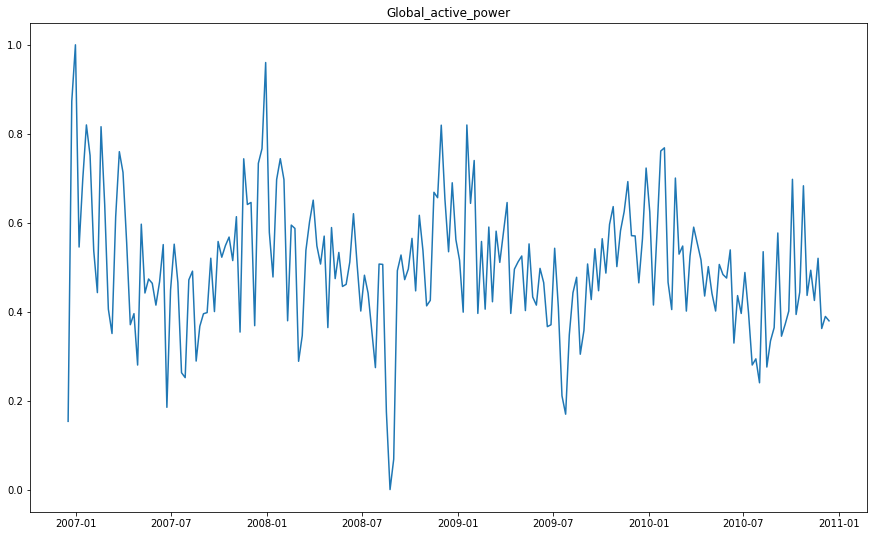

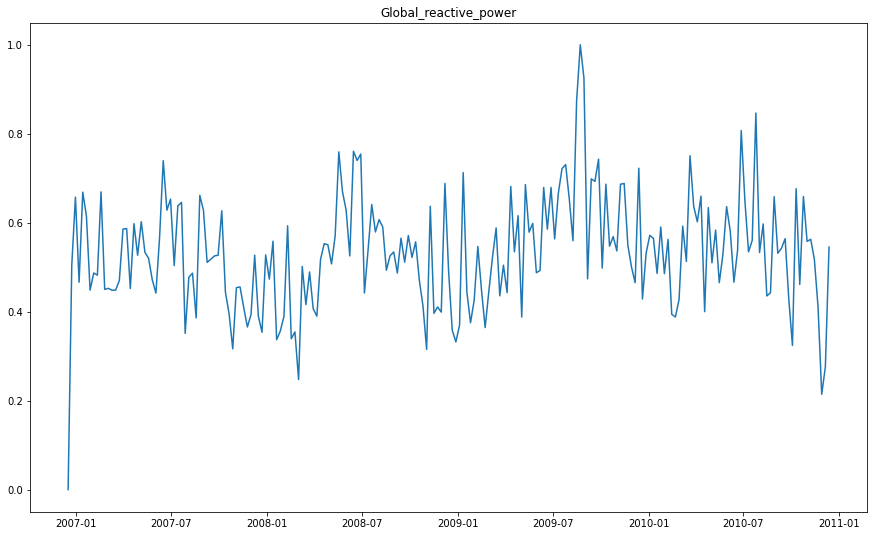

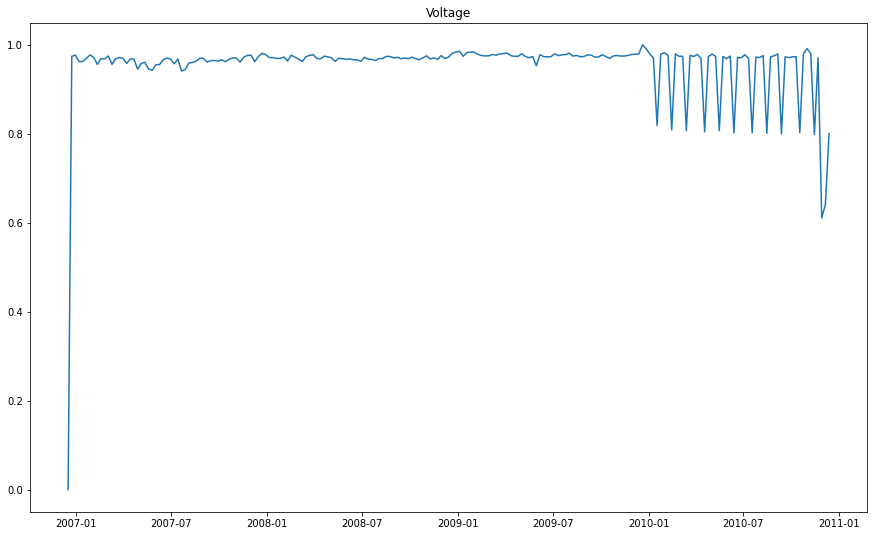

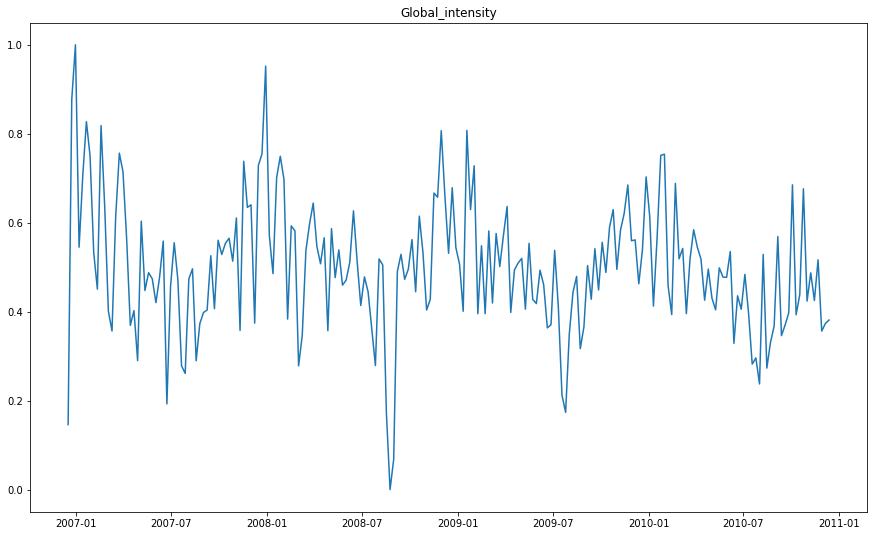

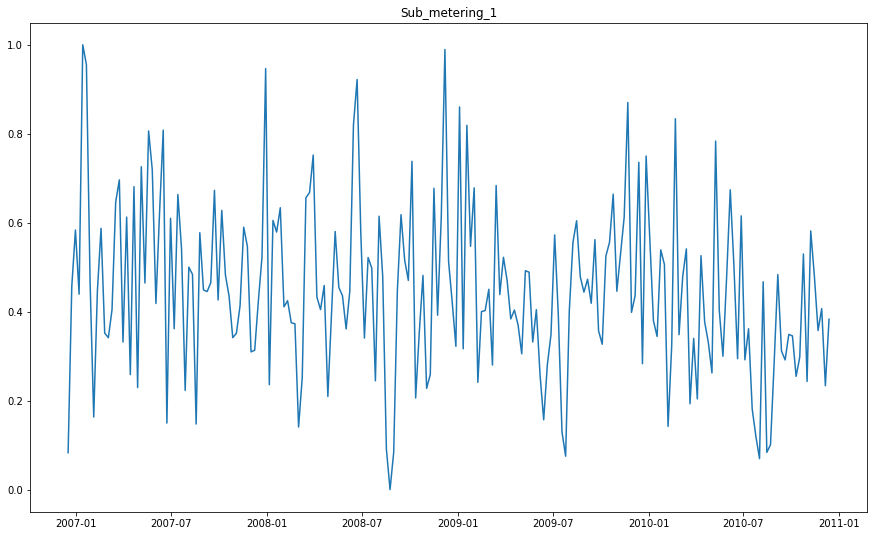

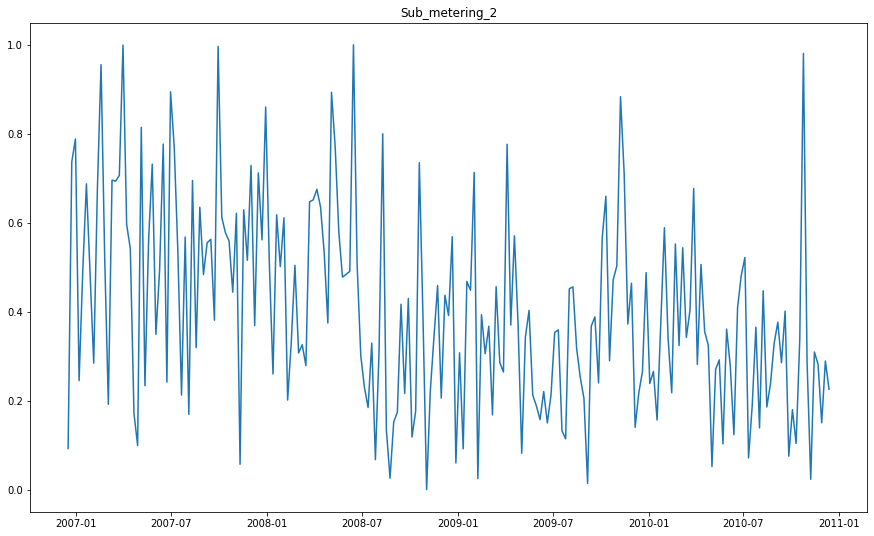

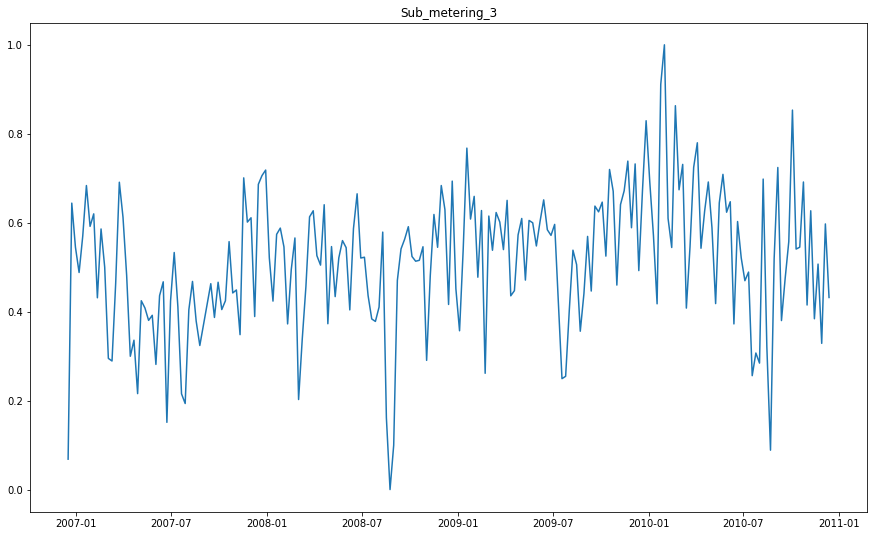

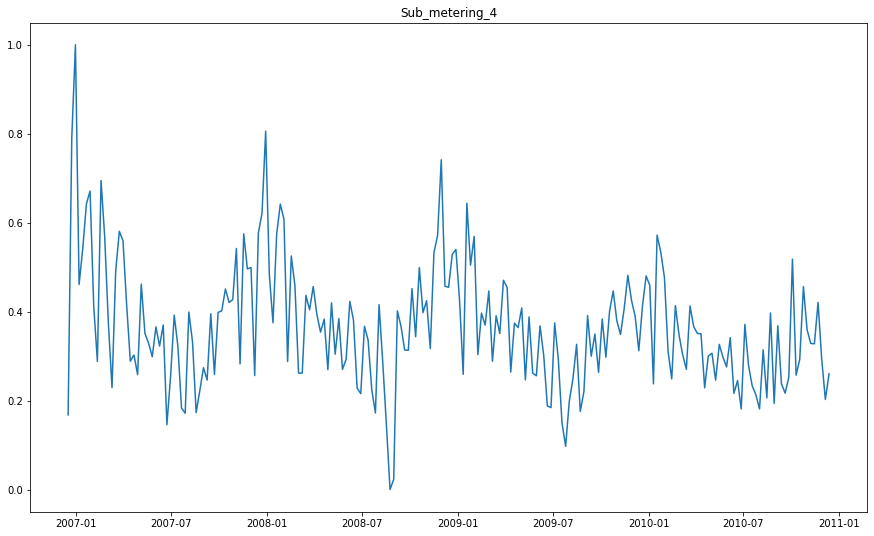

In [11]:
for column in data_df.columns:
    fig,ax = plt.subplots(figsize=(15,9))
    ax.plot(data_df[column])
    ax.set_title(column)
    plt.show()

# Train Models

Train Epoch: 100, Loss:        0.006699
Elapsed Time: 0:00:00.138271
Train Epoch: 100, Loss:        0.012443
Elapsed Time: 0:00:00.140123
Train Epoch: 100, Loss:        0.032901
Elapsed Time: 0:00:00.143867
Train Epoch: 100, Loss:        0.007174
Elapsed Time: 0:00:00.140185
Train Epoch: 100, Loss:        0.007969
Elapsed Time: 0:00:00.146242
Train Epoch: 100, Loss:        0.000212
Elapsed Time: 0:00:00.175935
Train Epoch: 100, Loss:        0.018568
Elapsed Time: 0:00:00.187952
Train Epoch: 100, Loss:        0.000042
Elapsed Time: 0:00:00.184809
Train Epoch: 100, Loss:        0.007963
Elapsed Time: 0:00:00.188414
Train Epoch: 100, Loss:        0.008268
Elapsed Time: 0:00:00.188245
Train Epoch: 100, Loss:        0.017935
Elapsed Time: 0:00:00.155058
Train Epoch: 100, Loss:        0.011162
Elapsed Time: 0:00:00.141669
Train Epoch: 100, Loss:        0.024911
Elapsed Time: 0:00:00.149819
Train Epoch: 100, Loss:        0.002651
Elapsed Time: 0:00:00.142121
Train Epoch: 100, Loss:        0.0

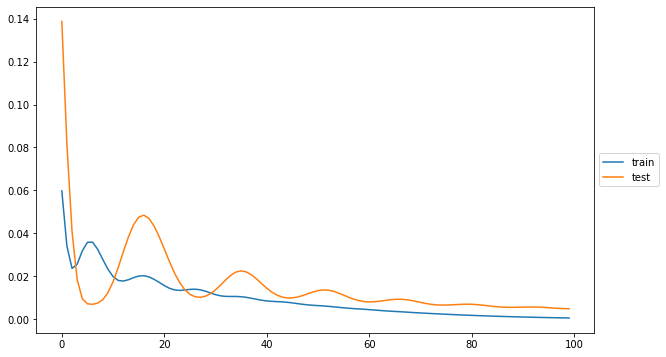

Train Epoch: 100, Loss:        0.021291
Elapsed Time: 0:00:00.171391
Train Epoch: 100, Loss:        0.016579
Elapsed Time: 0:00:00.179722
Train Epoch: 100, Loss:        0.017601
Elapsed Time: 0:00:00.179746
Train Epoch: 100, Loss:        0.020263
Elapsed Time: 0:00:00.180878
Train Epoch: 100, Loss:        0.011539
Elapsed Time: 0:00:00.182438
Train Epoch: 100, Loss:        0.007619
Elapsed Time: 0:00:00.220506
Train Epoch: 100, Loss:        0.016138
Elapsed Time: 0:00:00.224608
Train Epoch: 100, Loss:        0.010856
Elapsed Time: 0:00:00.234596
Train Epoch: 100, Loss:        0.002422
Elapsed Time: 0:00:00.230546
Train Epoch: 100, Loss:        0.005751
Elapsed Time: 0:00:00.225791
Train Epoch: 100, Loss:        0.011406
Elapsed Time: 0:00:00.184895
Train Epoch: 100, Loss:        0.010281
Elapsed Time: 0:00:00.180424
Train Epoch: 100, Loss:        0.011079
Elapsed Time: 0:00:00.177949
Train Epoch: 100, Loss:        0.006375
Elapsed Time: 0:00:00.183744
Train Epoch: 100, Loss:        0.0

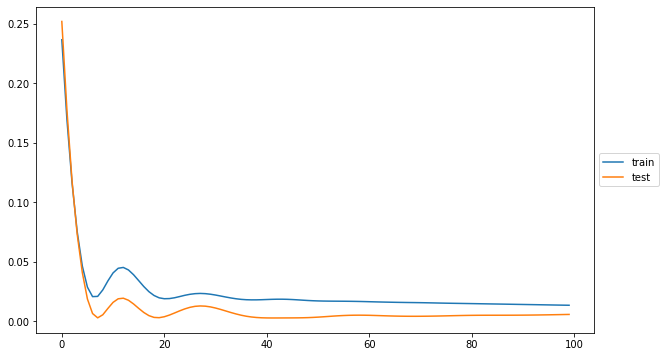

Train Epoch: 100, Loss:        0.017032
Elapsed Time: 0:00:00.278428
Train Epoch: 100, Loss:        0.022705
Elapsed Time: 0:00:00.295377
Train Epoch: 100, Loss:        0.019925
Elapsed Time: 0:00:00.315444
Train Epoch: 100, Loss:        0.020955
Elapsed Time: 0:00:00.293164
Train Epoch: 100, Loss:        0.017696
Elapsed Time: 0:00:00.292927
Train Epoch: 100, Loss:        0.012997
Elapsed Time: 0:00:00.359636
Train Epoch: 100, Loss:        0.021085
Elapsed Time: 0:00:00.381759
Train Epoch: 100, Loss:        0.014683
Elapsed Time: 0:00:00.379417
Train Epoch: 100, Loss:        0.012689
Elapsed Time: 0:00:00.375674
Train Epoch: 100, Loss:        0.012509
Elapsed Time: 0:00:00.374988
Train Epoch: 100, Loss:        0.018699
Elapsed Time: 0:00:00.281047
Train Epoch: 100, Loss:        0.024279
Elapsed Time: 0:00:00.301126
Train Epoch: 100, Loss:        0.023830
Elapsed Time: 0:00:00.294725
Train Epoch: 100, Loss:        0.020167
Elapsed Time: 0:00:00.294776
Train Epoch: 100, Loss:        0.0

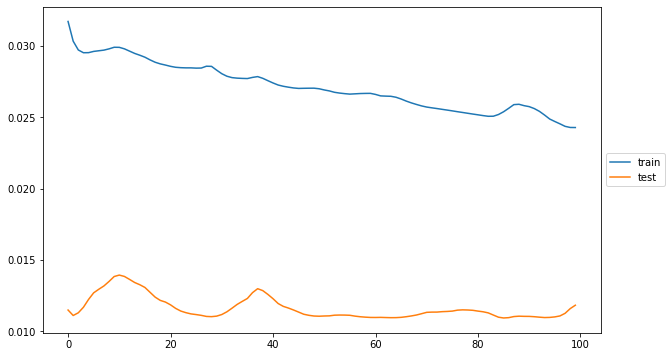

Train Epoch: 100, Loss:        0.014646
Elapsed Time: 0:00:00.314807
Train Epoch: 100, Loss:        0.016693
Elapsed Time: 0:00:00.331923
Train Epoch: 100, Loss:        0.019419
Elapsed Time: 0:00:00.335867
Train Epoch: 100, Loss:        0.289234
Elapsed Time: 0:00:00.331687
Train Epoch: 100, Loss:        0.021227
Elapsed Time: 0:00:00.331711
Train Epoch: 100, Loss:        0.011442
Elapsed Time: 0:00:00.415800
Train Epoch: 100, Loss:        0.018061
Elapsed Time: 0:00:00.420984
Train Epoch: 100, Loss:        0.013833
Elapsed Time: 0:00:00.419677
Train Epoch: 100, Loss:        0.017398
Elapsed Time: 0:00:00.415147
Train Epoch: 100, Loss:        0.016118
Elapsed Time: 0:00:00.415381
Train Epoch: 100, Loss:        0.018536
Elapsed Time: 0:00:00.309368
Train Epoch: 100, Loss:        0.019521
Elapsed Time: 0:00:00.328593
Train Epoch: 100, Loss:        0.016279
Elapsed Time: 0:00:00.326262
Train Epoch: 100, Loss:        0.017245
Elapsed Time: 0:00:00.341723
Train Epoch: 100, Loss:        0.0

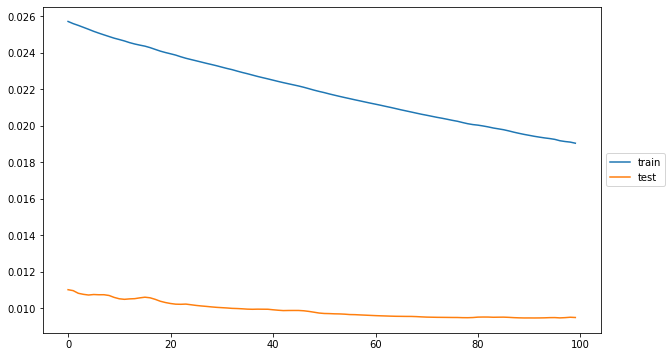

Train Epoch: 100, Loss:        0.027038
Elapsed Time: 0:00:00.340326
Train Epoch: 100, Loss:        0.019951
Elapsed Time: 0:00:00.365101
Train Epoch: 100, Loss:        0.020294
Elapsed Time: 0:00:00.361807
Train Epoch: 100, Loss:        0.016593
Elapsed Time: 0:00:00.375412
Train Epoch: 100, Loss:        0.022231
Elapsed Time: 0:00:00.365002
Train Epoch: 100, Loss:        0.012015
Elapsed Time: 0:00:00.432488
Train Epoch: 100, Loss:        0.011438
Elapsed Time: 0:00:00.451899
Train Epoch: 100, Loss:        0.013085
Elapsed Time: 0:00:00.458294
Train Epoch: 100, Loss:        0.008267
Elapsed Time: 0:00:00.454936
Train Epoch: 100, Loss:        0.012117
Elapsed Time: 0:00:00.456554
Train Epoch: 100, Loss:        0.028334
Elapsed Time: 0:00:00.357163
Train Epoch: 100, Loss:        0.015317
Elapsed Time: 0:00:00.363780
Train Epoch: 100, Loss:        0.026296
Elapsed Time: 0:00:00.359509
Train Epoch: 100, Loss:        0.264682
Elapsed Time: 0:00:00.364513
Train Epoch: 100, Loss:        0.0

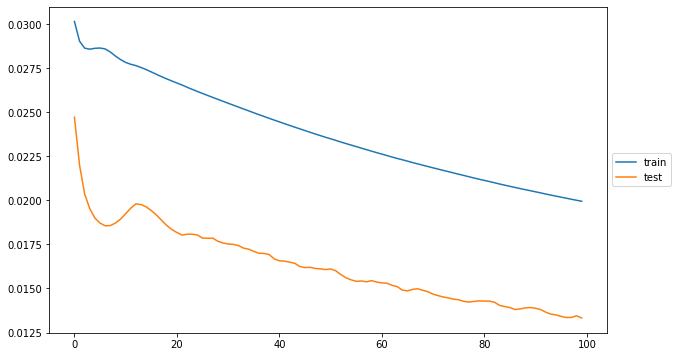

Train Epoch: 100, Loss:        0.021669
Elapsed Time: 0:00:00.456879
Train Epoch: 100, Loss:        0.014246
Elapsed Time: 0:00:00.478948
Train Epoch: 100, Loss:        0.014704
Elapsed Time: 0:00:00.480653
Train Epoch: 100, Loss:        0.015830
Elapsed Time: 0:00:00.486897
Train Epoch: 100, Loss:        0.022980
Elapsed Time: 0:00:00.480488
Train Epoch: 100, Loss:        0.008757
Elapsed Time: 0:00:00.577645
Train Epoch: 100, Loss:        0.015041
Elapsed Time: 0:00:00.607500
Train Epoch: 100, Loss:        0.008295
Elapsed Time: 0:00:00.607849
Train Epoch: 100, Loss:        0.012640
Elapsed Time: 0:00:00.603239
Train Epoch: 100, Loss:        0.012929
Elapsed Time: 0:00:00.617380
Train Epoch: 100, Loss:        0.018690
Elapsed Time: 0:00:00.458360
Train Epoch: 100, Loss:        0.019082
Elapsed Time: 0:00:00.475490
Train Epoch: 100, Loss:        0.021444
Elapsed Time: 0:00:00.476885
Train Epoch: 100, Loss:        0.303334
Elapsed Time: 0:00:00.480374
Train Epoch: 100, Loss:        0.0

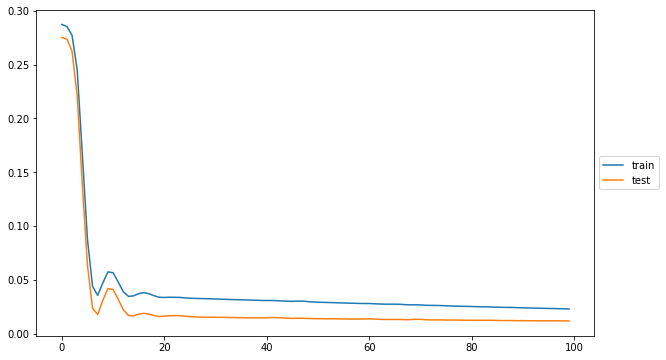

Train Epoch: 100, Loss:        0.012392
Elapsed Time: 0:00:00.484800
Train Epoch: 100, Loss:        0.016409
Elapsed Time: 0:00:00.662902
Train Epoch: 100, Loss:        0.021295
Elapsed Time: 0:00:00.507720
Train Epoch: 100, Loss:        0.015099
Elapsed Time: 0:00:00.519594
Train Epoch: 100, Loss:        0.016772
Elapsed Time: 0:00:00.510866
Train Epoch: 100, Loss:        0.008610
Elapsed Time: 0:00:00.613496
Train Epoch: 100, Loss:        0.018855
Elapsed Time: 0:00:00.643508
Train Epoch: 100, Loss:        0.009600
Elapsed Time: 0:00:00.649169
Train Epoch: 100, Loss:        0.013327
Elapsed Time: 0:00:00.655790
Train Epoch: 100, Loss:        0.008367
Elapsed Time: 0:00:00.638446
Train Epoch: 100, Loss:        0.016389
Elapsed Time: 0:00:00.491361
Train Epoch: 100, Loss:        0.017203
Elapsed Time: 0:00:00.506277
Train Epoch: 100, Loss:        0.018108
Elapsed Time: 0:00:00.513596
Train Epoch: 100, Loss:        0.013512
Elapsed Time: 0:00:00.508218
Train Epoch: 100, Loss:        0.0

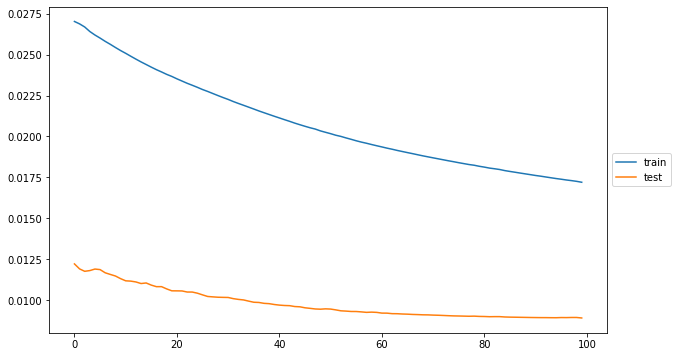

Train Epoch: 100, Loss:        0.019457
Elapsed Time: 0:00:00.623359
Train Epoch: 100, Loss:        0.015646
Elapsed Time: 0:00:00.641096
Train Epoch: 100, Loss:        0.013904
Elapsed Time: 0:00:00.645355
Train Epoch: 100, Loss:        0.012515
Elapsed Time: 0:00:00.634943
Train Epoch: 100, Loss:        0.015542
Elapsed Time: 0:00:00.638049
Train Epoch: 100, Loss:        0.008515
Elapsed Time: 0:00:00.790222
Train Epoch: 100, Loss:        0.012985
Elapsed Time: 0:00:00.812169
Train Epoch: 100, Loss:        0.011284
Elapsed Time: 0:00:00.815821
Train Epoch: 100, Loss:        0.013841
Elapsed Time: 0:00:00.808598
Train Epoch: 100, Loss:        0.010540
Elapsed Time: 0:00:00.822157
Train Epoch: 100, Loss:        0.011793
Elapsed Time: 0:00:00.611356
Train Epoch: 100, Loss:        0.012705
Elapsed Time: 0:00:00.641690
Train Epoch: 100, Loss:        0.022770
Elapsed Time: 0:00:00.645262
Train Epoch: 100, Loss:        0.013769
Elapsed Time: 0:00:00.659368
Train Epoch: 100, Loss:        0.0

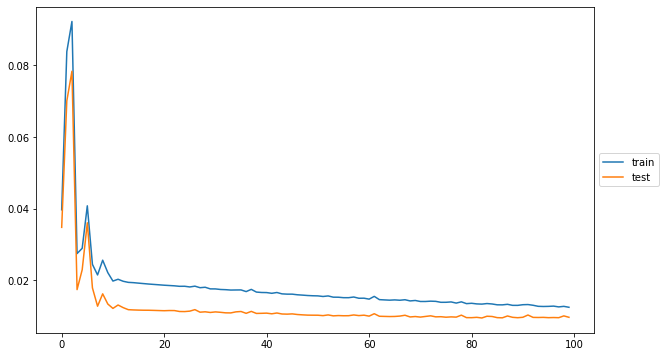

Train Epoch: 100, Loss:        0.014335
Elapsed Time: 0:00:00.653334
Train Epoch: 100, Loss:        0.013799
Elapsed Time: 0:00:00.676971
Train Epoch: 100, Loss:        0.016254
Elapsed Time: 0:00:00.672994
Train Epoch: 100, Loss:        0.010990
Elapsed Time: 0:00:00.669522
Train Epoch: 100, Loss:        0.014625
Elapsed Time: 0:00:00.673610
Train Epoch: 100, Loss:        0.010510
Elapsed Time: 0:00:00.822358
Train Epoch: 100, Loss:        0.011434
Elapsed Time: 0:00:00.847905
Train Epoch: 100, Loss:        0.010432
Elapsed Time: 0:00:00.850385
Train Epoch: 100, Loss:        0.010325
Elapsed Time: 0:00:00.863068
Train Epoch: 100, Loss:        0.008190
Elapsed Time: 0:00:00.842502
Train Epoch: 100, Loss:        0.011978
Elapsed Time: 0:00:00.644568
Train Epoch: 100, Loss:        0.013999
Elapsed Time: 0:00:00.671895
Train Epoch: 100, Loss:        0.016976
Elapsed Time: 0:00:00.684247
Train Epoch: 100, Loss:        0.285774
Elapsed Time: 0:00:00.670012
Train Epoch: 100, Loss:        0.0

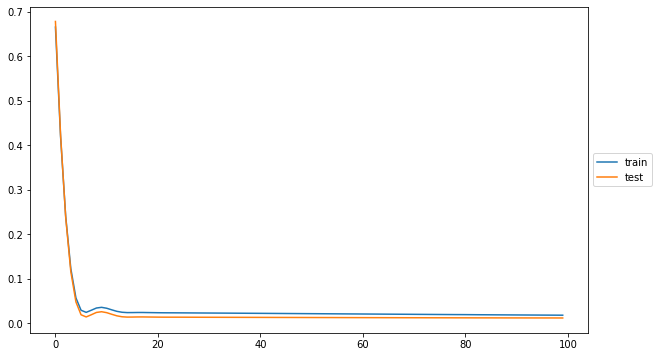

Train Epoch: 100, Loss:        0.020251
Elapsed Time: 0:00:00.741402
Train Epoch: 100, Loss:        0.013058
Elapsed Time: 0:00:00.776429
Train Epoch: 100, Loss:        0.011279
Elapsed Time: 0:00:00.790745
Train Epoch: 100, Loss:        0.013809
Elapsed Time: 0:00:00.775221
Train Epoch: 100, Loss:        0.014387
Elapsed Time: 0:00:00.773989
Train Epoch: 100, Loss:        0.010645
Elapsed Time: 0:00:00.944672
Train Epoch: 100, Loss:        0.013447
Elapsed Time: 0:00:01.001802
Train Epoch: 100, Loss:        0.008759
Elapsed Time: 0:00:00.990399
Train Epoch: 100, Loss:        0.011387
Elapsed Time: 0:00:00.985852
Train Epoch: 100, Loss:        0.011749
Elapsed Time: 0:00:01.006419
Train Epoch: 100, Loss:        0.014147
Elapsed Time: 0:00:00.745999
Train Epoch: 100, Loss:        0.013350
Elapsed Time: 0:00:00.781034
Train Epoch: 100, Loss:        0.015483
Elapsed Time: 0:00:00.796670
Train Epoch: 100, Loss:        0.009902
Elapsed Time: 0:00:00.777818
Train Epoch: 100, Loss:        0.0

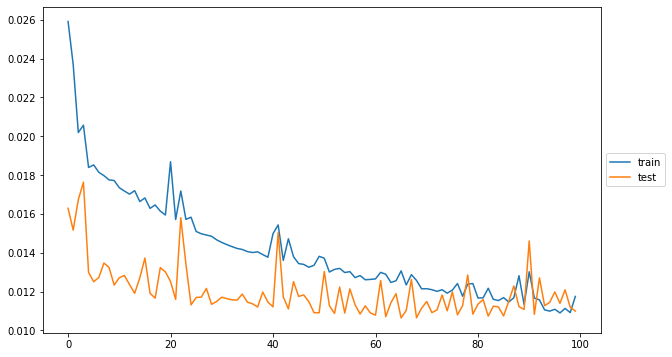

In [12]:
tscv = sklearn.model_selection.TimeSeriesSplit(
    n_splits=n_splits,
    max_train_size=max_train_size,
    test_size=test_size
)

def train_model(item):
    XX,yy,model = item
    model.fit(XX, yy)
    return model

models = list()
for ii,train_idx,test_idx in enumerate(tscv.split(data_df)):
    display(HTML("<h1>Split {}</h1>".format(ii+1)))
        
    train_df = data_df.iloc[train_idx].copy()
    XX = np.asarray([
        train_df.loc[:,pd.IndexSlice[features]].values[ii:ii+seq_len].reshape(-1)
        for ii in range(len(train_df)-seq_len)
    ])
    yy = np.asarray([
        train_df.loc[:,pd.IndexSlice[target]].values[ii+seq_len]
        for ii in range(len(train_df)-seq_len)
    ]).reshape(-1,1)

    work = [
        (
            XX,
            yy,
            ANN(
                model=model_num,
                n_epochs=100,
                batch_learning=False,
                batch_size=32,
                shuffle=True,
                compute_device="cpu",
                parallel=False,
                verbose=1,
            )
        )
        for ii in range(5)
        for model_num in range(10)
    ]
    tmp_models = list(map(train_model, work))
    tmp_models.sort(key=lambda model:model.validate_errors[-1])
    best_model = tmp_models[0]
    models.append(best_model)
    print(best_model._model)
    display_loss_curve(best_model)

# Walk-Forward Evaluation

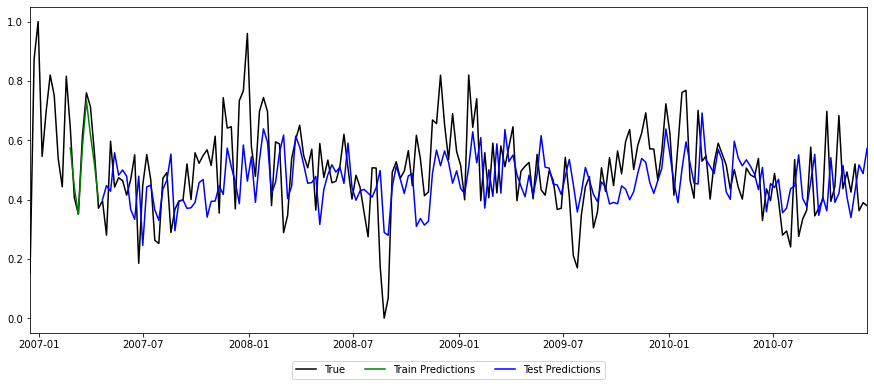

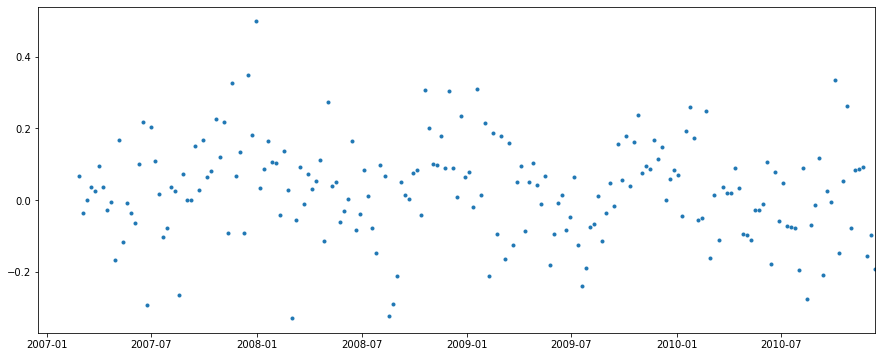

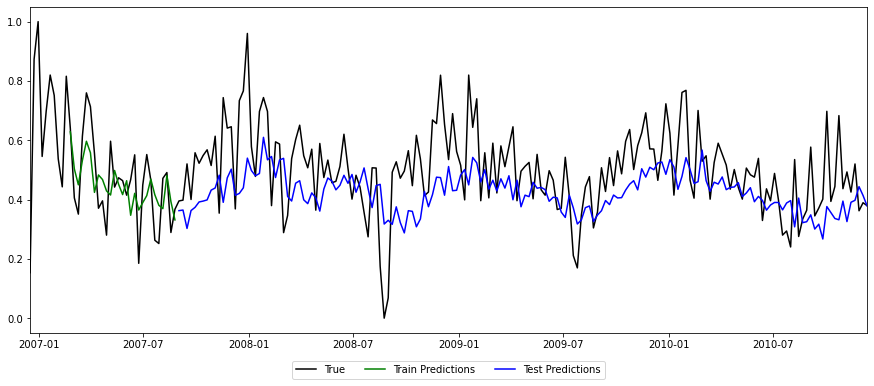

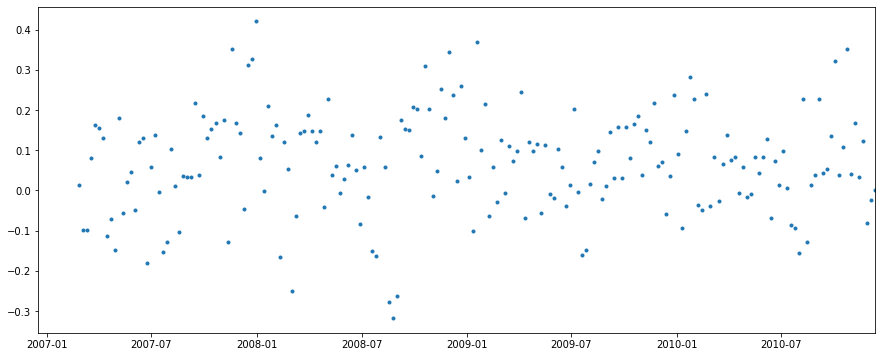

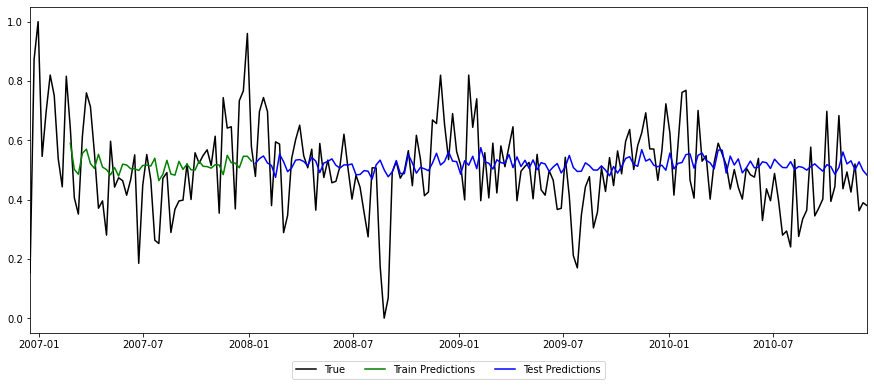

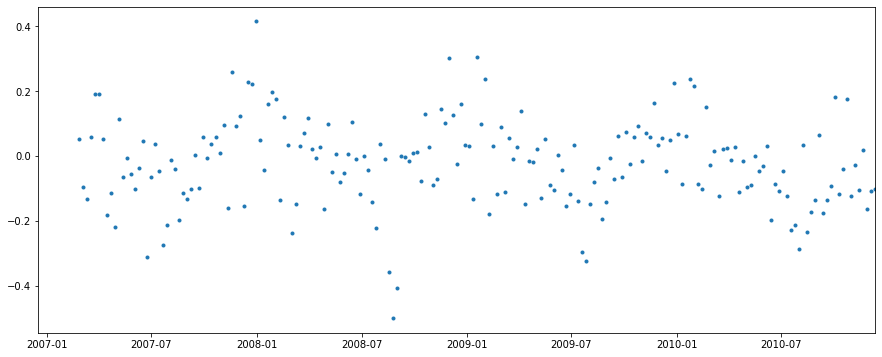

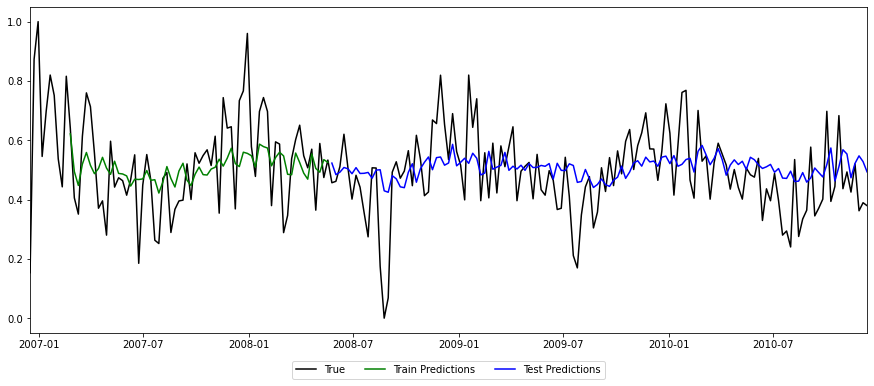

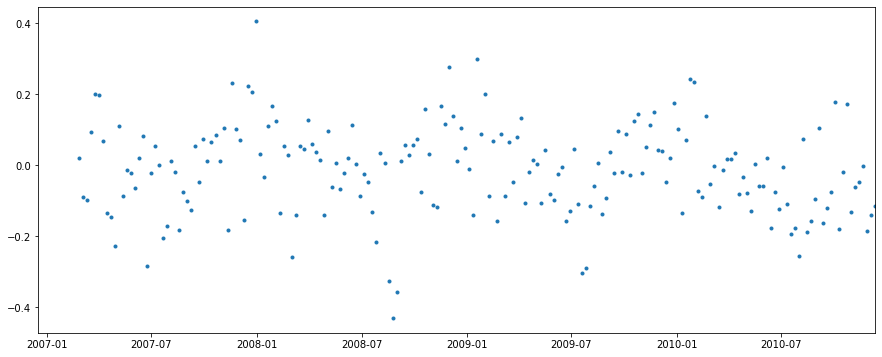

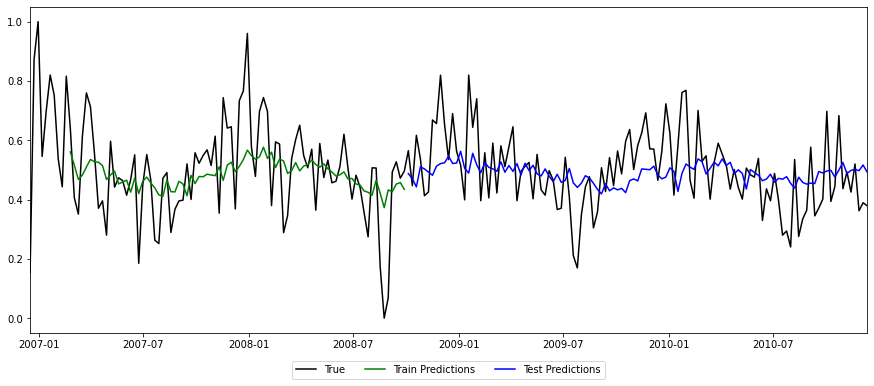

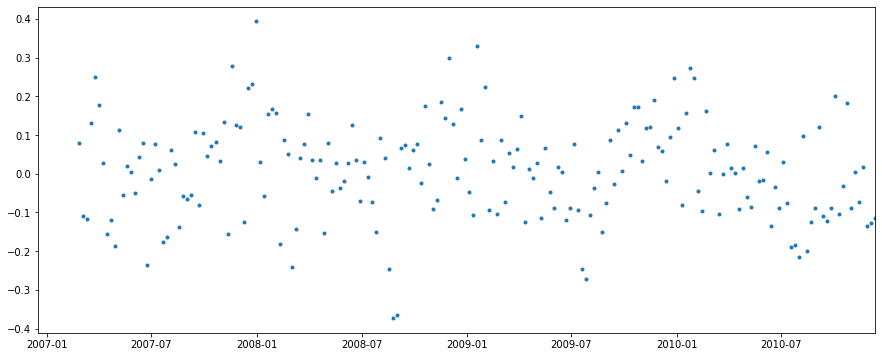

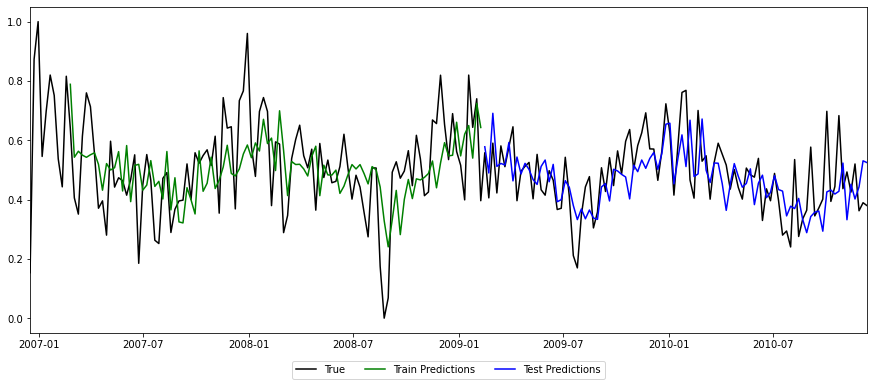

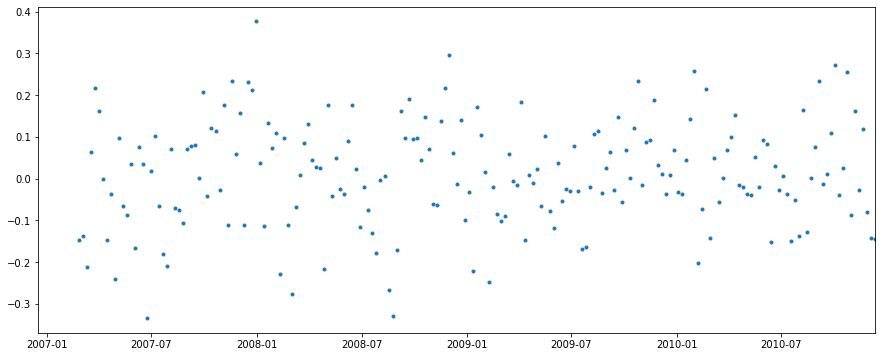

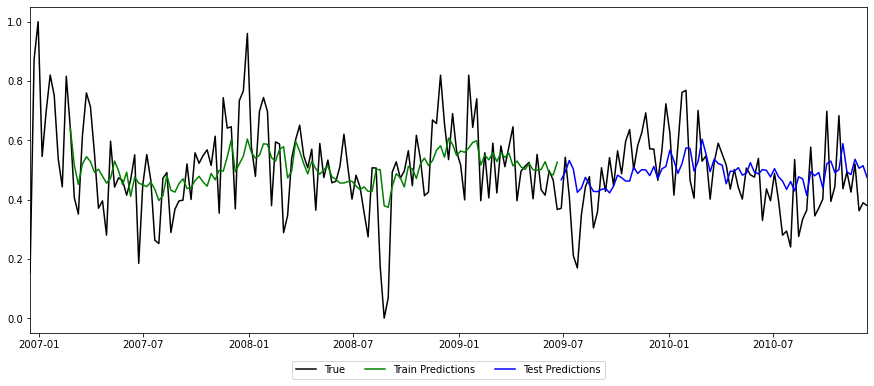

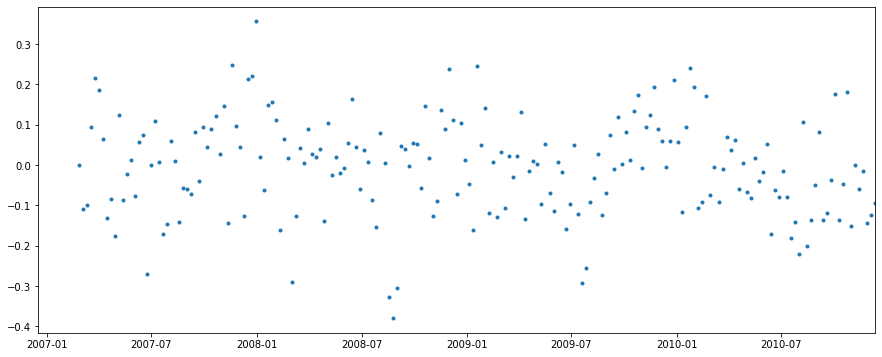

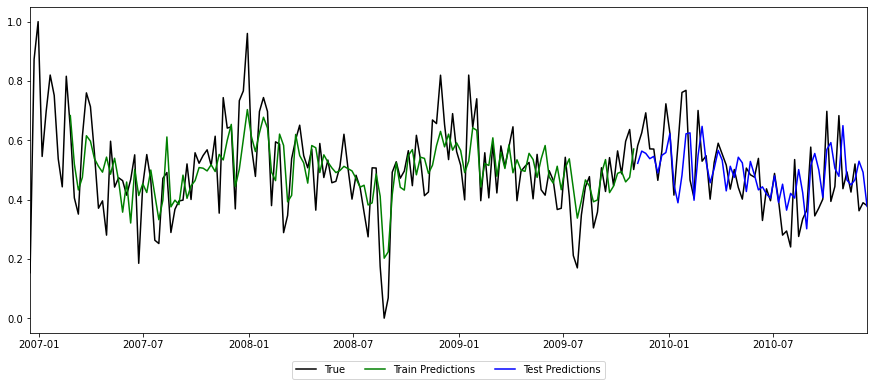

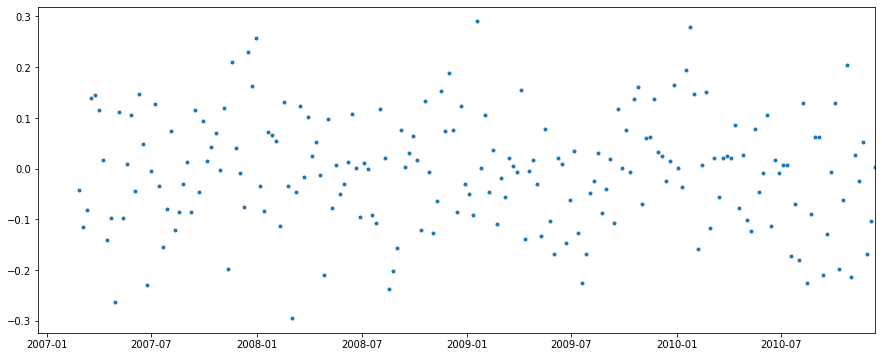

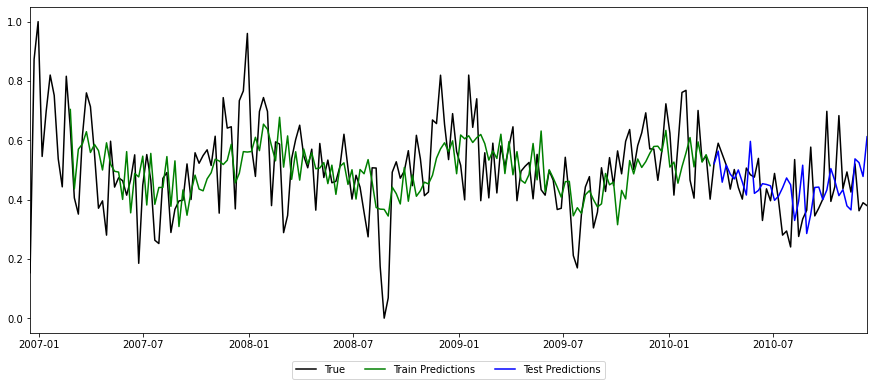

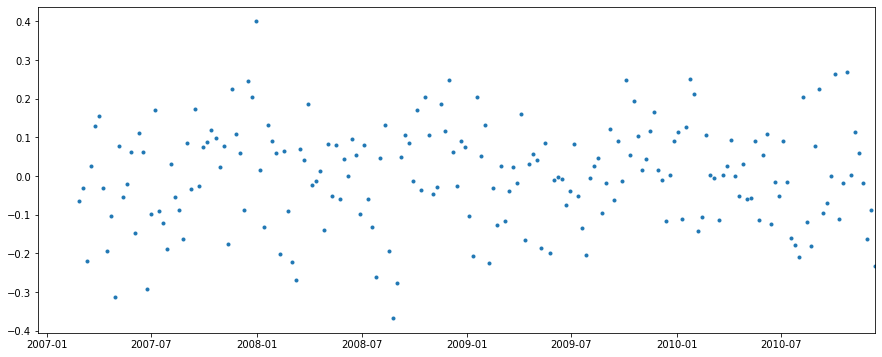

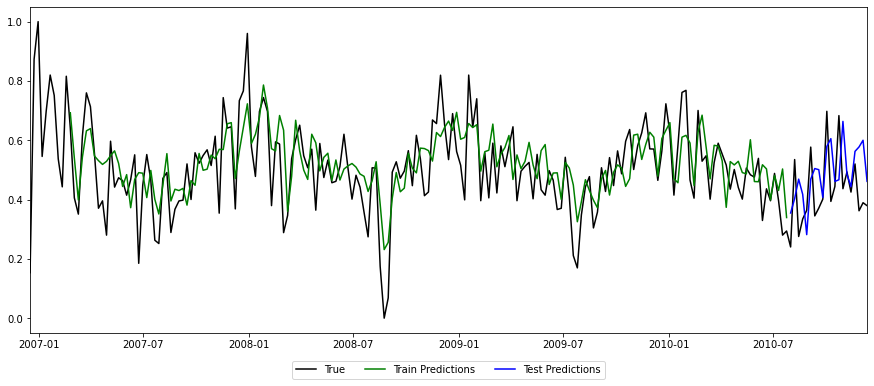

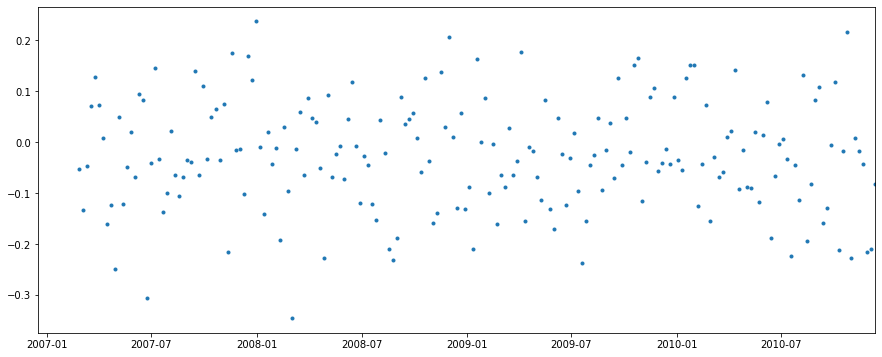

In [13]:
def evaluate_model(model, sample_df, features, seq_len):
    XX_tmp = np.asarray([
        sample_df.loc[:,pd.IndexSlice[features]].values[ii:ii+seq_len].reshape(-1)
        for ii in range(len(sample_df)-seq_len)
    ])
    return np.asarray([np.nan for ii in range(seq_len)] + np.squeeze(model.predict(XX_tmp)).tolist())

for ii,(model,(train_idx,test_idx)) in enumerate(zip(models,tscv.split(data_df))):
    display(HTML("<h1>Split {}</h1>".format(ii+1)))
    
    results_df = data_df.copy()
    result = evaluate_model(model, results_df, features, seq_len)
    results_df["Predicted"] = result
    results_df["Residuals"] = np.squeeze(results_df.loc[:,pd.IndexSlice[target]].values) - results_df["Predicted"]

    fig,ax = plt.subplots(figsize=(15,6))
    ax.plot(results_df.loc[:,pd.IndexSlice[target]], color="black", label="True")
    ax.plot(results_df.iloc[:train_idx[-1]]["Predicted"], color="green", label="Train Predictions")
    ax.plot(results_df.iloc[train_idx[-1]:]["Predicted"], color="blue", label="Test Predictions")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.07), ncol=3)
    ax.set_xlim(np.min(results_df.index), np.max(results_df.index))
    plt.show()

    fig,ax = plt.subplots(figsize=(15,6))
    ax.scatter(results_df.index, results_df["Residuals"], marker=".")
    ax.set_xlim(np.min(results_df.index), np.max(results_df.index))
    plt.show()

# ? Evaluation

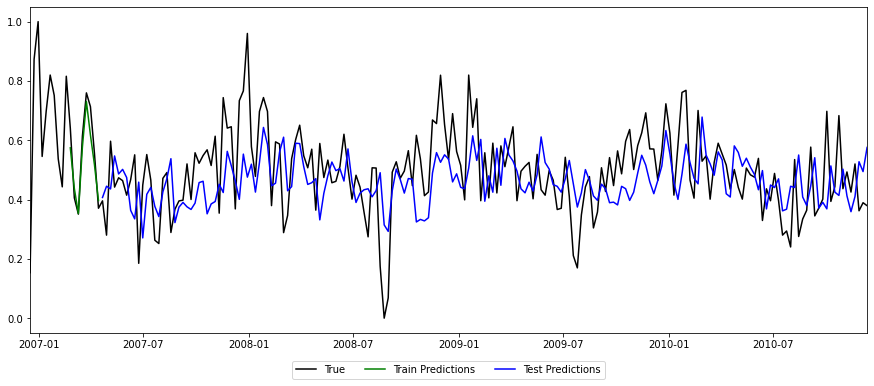

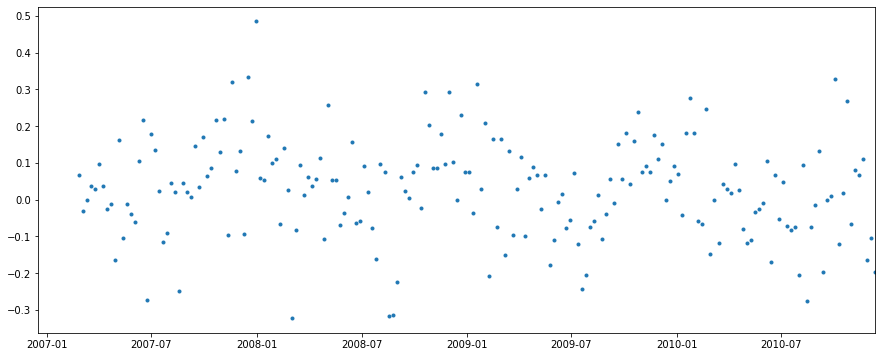

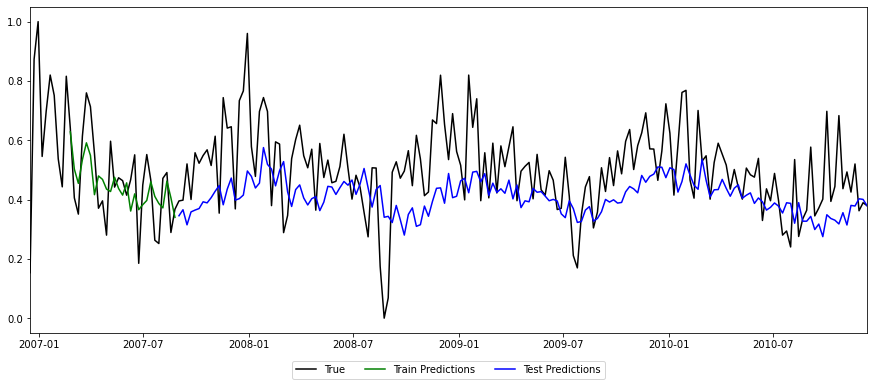

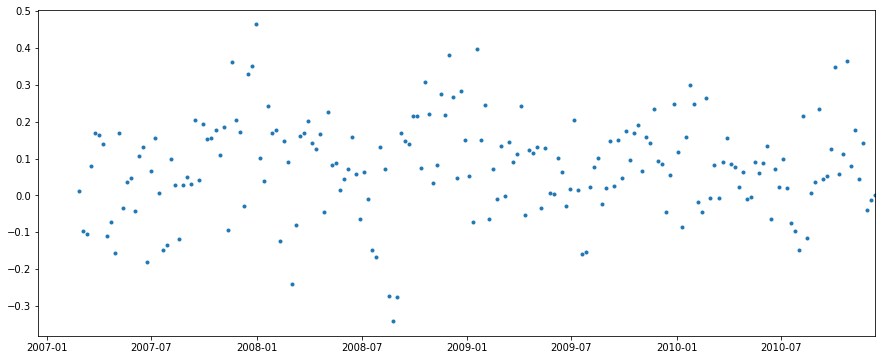

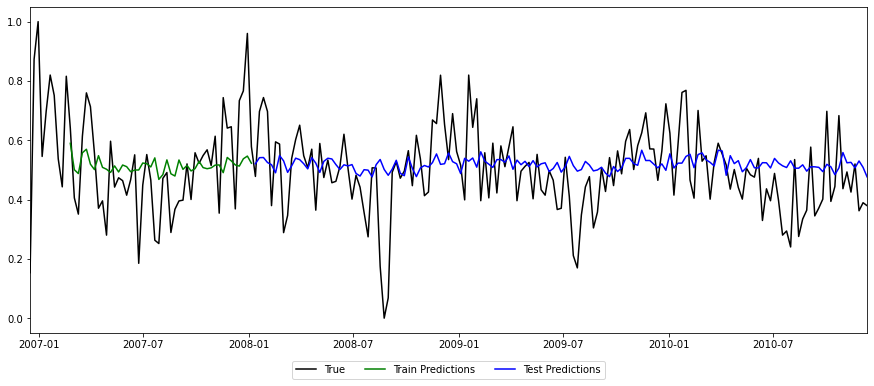

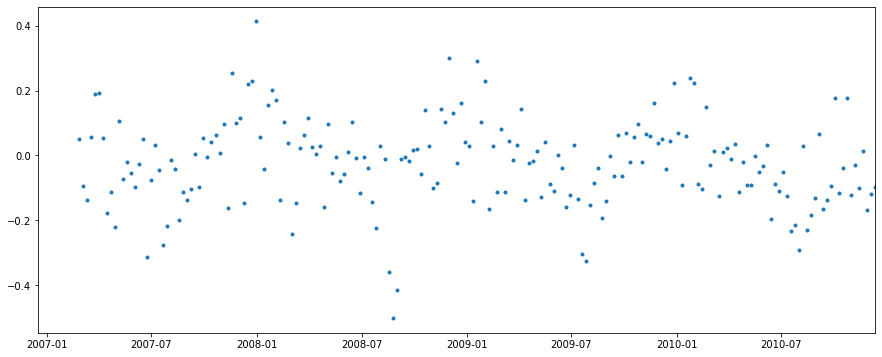

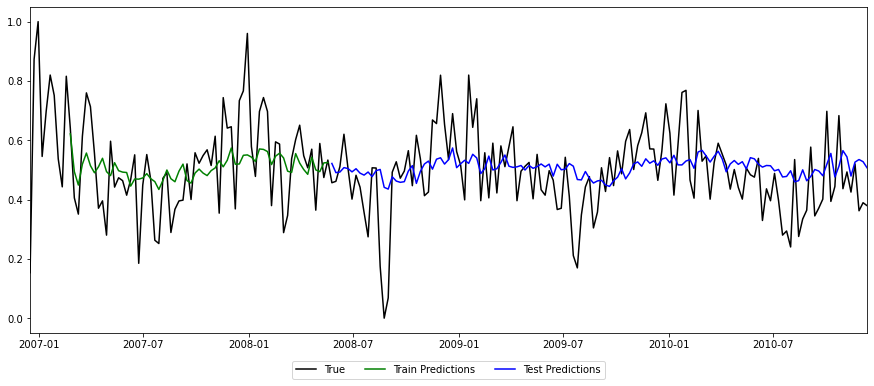

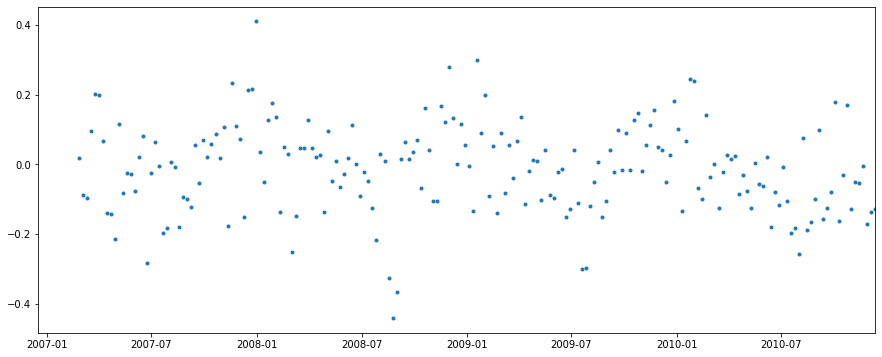

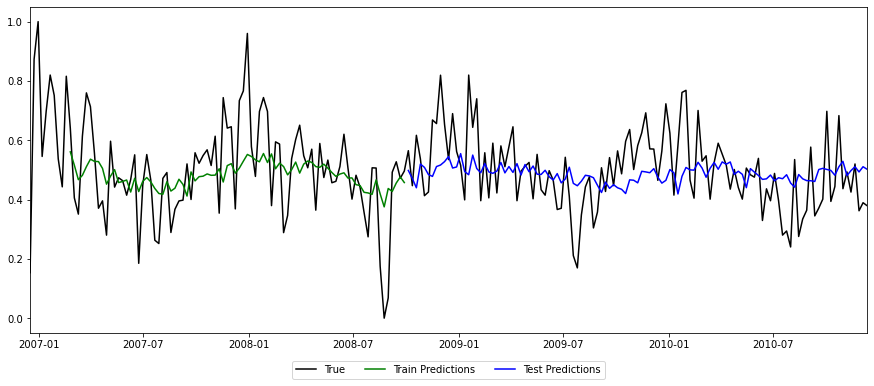

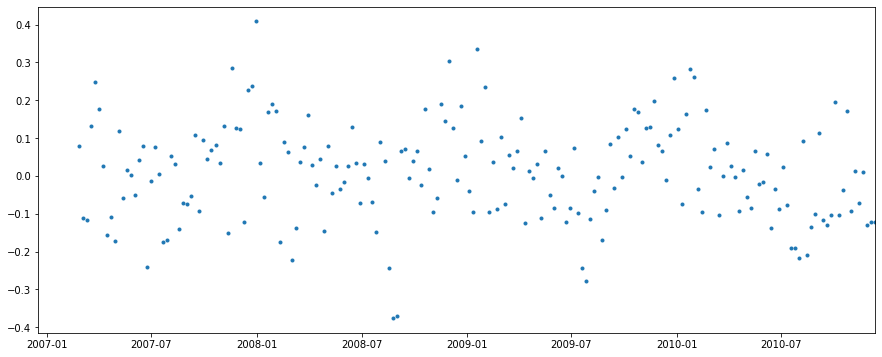

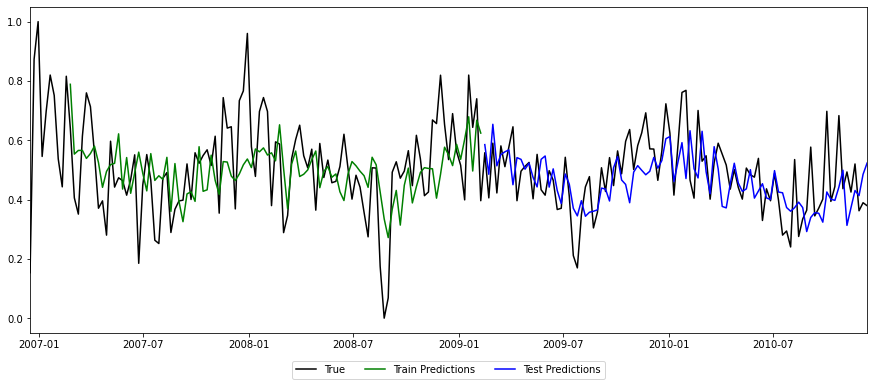

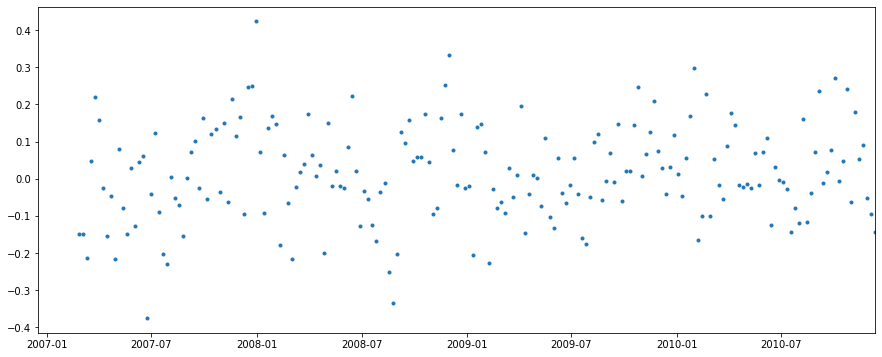

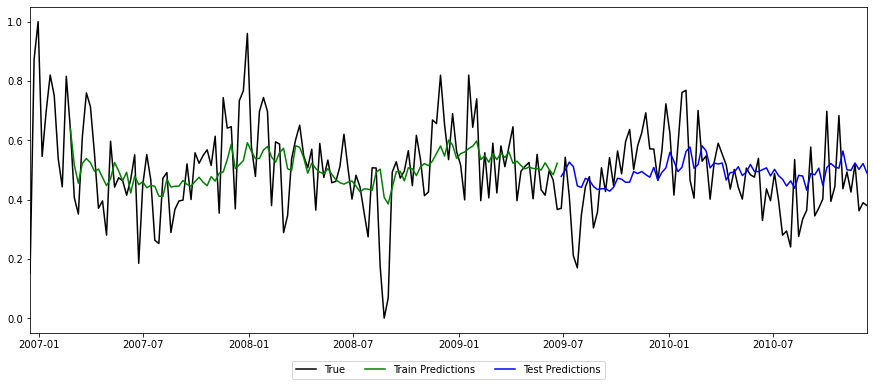

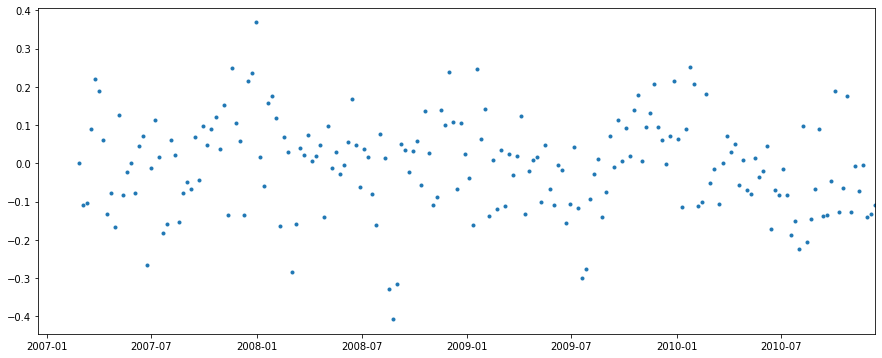

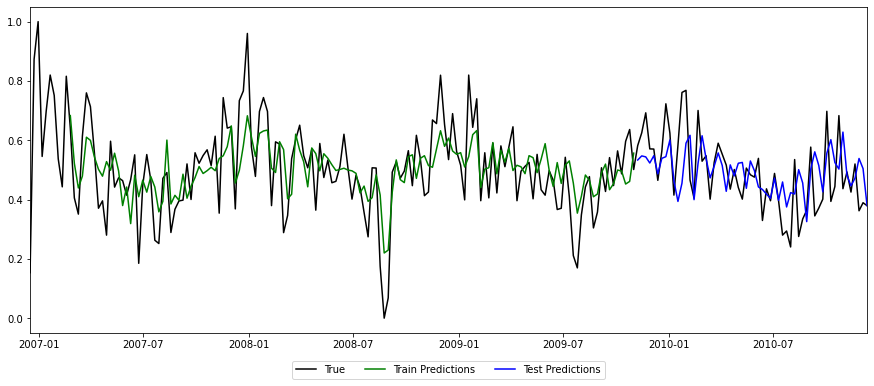

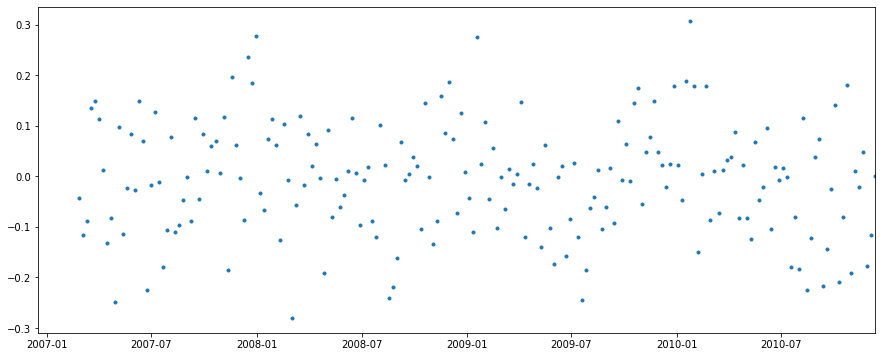

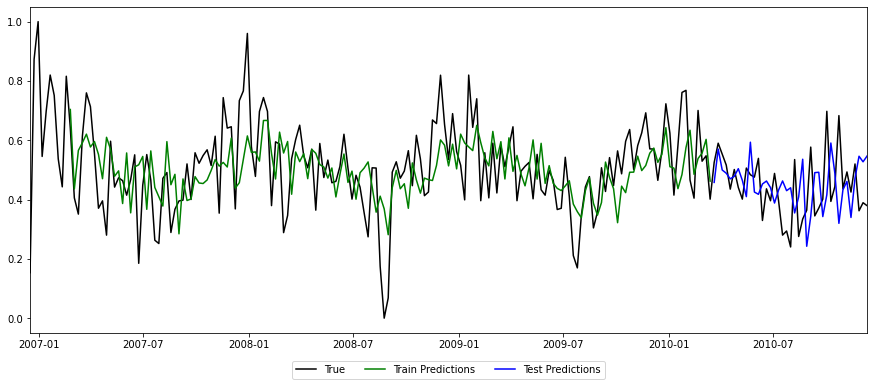

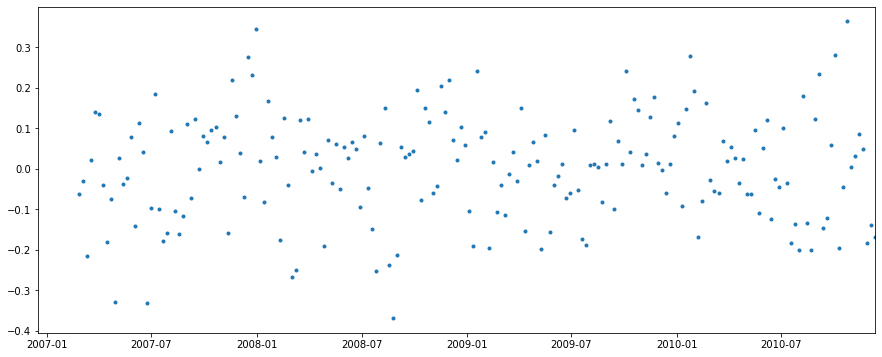

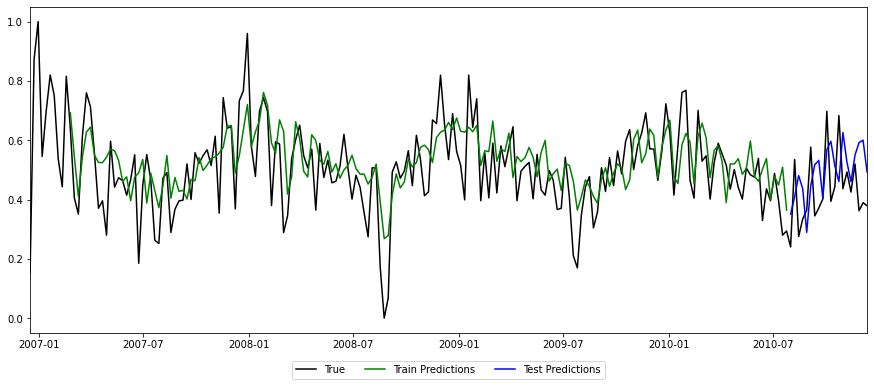

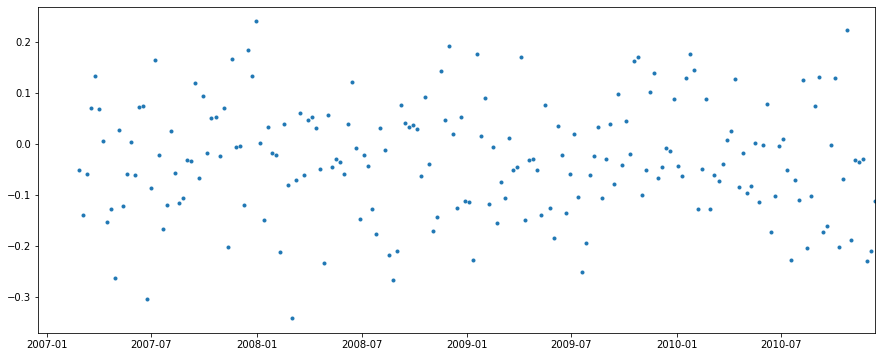

In [14]:
def evaluate_model(model, sample_df, features, seq_len):
    sample_df = sample_df.copy()
    yy_pred = [np.nan] * seq_len
    for ii in range(len(sample_df)-seq_len):
        single_x = sample_df.loc[:,pd.IndexSlice[features]].values[ii:ii+seq_len].reshape(1,-1).copy()
        try:
            yy_pred.append( np.squeeze(model.predict(single_x)).item() )
            if target in features:
                sample_df.at[sample_df.index[ii+seq_len],pd.IndexSlice[target]] = yy_pred[-1]
        except:
            yy_pred.extend( [np.nan for jj in range(ii, len(sample_df)-seq_len)] )
            break
    return np.asarray(yy_pred)

for ii,(model,(train_idx,test_idx)) in enumerate(zip(models,tscv.split(data_df))):
    display(HTML("<h1>Split {}</h1>".format(ii+1)))
    
    results_df = data_df.copy()
    result = evaluate_model(model, results_df, features, seq_len)
    results_df["Predicted"] = result
    results_df["Residuals"] = np.squeeze(results_df.loc[:,pd.IndexSlice[target]].values) - results_df["Predicted"]

    fig,ax = plt.subplots(figsize=(15,6))
    ax.plot(results_df.loc[:,pd.IndexSlice[target]], color="black", label="True")
    ax.plot(results_df.iloc[:train_idx[-1]]["Predicted"], color="green", label="Train Predictions")
    ax.plot(results_df.iloc[train_idx[-1]:]["Predicted"], color="blue", label="Test Predictions")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.07), ncol=3)
    ax.set_xlim(np.min(results_df.index), np.max(results_df.index))
    plt.show()

    fig,ax = plt.subplots(figsize=(15,6))
    ax.scatter(results_df.index, results_df["Residuals"], marker=".")
    ax.set_xlim(np.min(results_df.index), np.max(results_df.index))
    plt.show()